In [320]:
pip install pandas numpy scikit-learn matplotlib seaborn imblearn shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/61/8d/d0790fbbde36aeed7e87516f15d163daddb07ca34c6f736e29e02bddf4c7/shap-0.44.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for cloudpickle from https://files.pythonhosted.org/packages/96/43/dae06432d0c4b1dc9e9149ad37b4ca8384cf6eb7700cd9215b177b914f0a/cloudpickle-3.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/448.0 kB ? eta -:--:--
   --------------------------------------  440.3/448.0 kB 13.9 MB/s eta 0:00:01
   ---------------------------------------- 448.0/448.0 kB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\lzyda\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [234]:
## Data Acquisition and Processing 

In [262]:
import pandas as pd

nhgh_file_path = "./nhgh.tsv"
data = pd.read_csv(nhgh_file_path, sep='\t')

data.head()

,seqn,sex,age,re,income,tx,dx,wt,ht,bmi,leg,arml,armc,waist,tri,sub,gh,albumin,bun,SCr
0,51624,male,34.166667,Non-Hispanic White,"[25000,35000)",0,0,87.4,164.7,32.22,41.5,40.0,36.4,100.4,16.4,24.9,5.2,4.8,6.0,0.94
1,51626,male,16.833333,Non-Hispanic Black,"[45000,55000)",0,0,72.3,181.3,22.00,42.0,39.5,26.6,74.7,10.2,10.5,5.7,4.6,9.0,0.89
2,51628,female,60.166667,Non-Hispanic Black,"[10000,15000)",1,1,116.8,166.0,42.39,35.3,39.0,42.2,118.2,29.6,35.6,6.0,3.9,10.0,1.11
3,51629,male,26.083333,Mexican American,"[25000,35000)",0,0,97.6,173.0,32.61,41.7,38.7,37.0,103.7,19.0,23.2,5.1,4.2,8.0,0.80
4,51630,female,49.666667,Non-Hispanic White,"[35000,45000)",0,0,86.7,168.4,30.57,37.5,36.1,33.3,107.8,30.3,28.0,5.3,4.3,13.0,0.79


In [263]:
# Convert to tidy format and ensure data types are correct and consistent

# Check for missing values
missing_values = data.isnull().sum()

# Normalize strings to lowercase
data.columns = [col.lower() for col in data.columns]

print("Missing Values:\n", missing_values)
print("\nData Types:\n", data.dtypes)

Missing Values:
 seqn         0
sex          0
age          0
re           0
income     320
tx           0
dx           0
wt           0
ht           0
bmi          0
leg        231
arml       179
armc       188
waist      239
tri        481
sub        971
gh           0
albumin     89
bun         89
SCr         89
dtype: int64

Data Types:
 seqn         int64
sex         object
age        float64
re          object
income      object
tx           int64
dx           int64
wt         float64
ht         float64
bmi        float64
leg        float64
arml       float64
armc       float64
waist      float64
tri        float64
sub        float64
gh         float64
albumin    float64
bun        float64
scr        float64
dtype: object


In [264]:
from sklearn.impute import SimpleImputer

# Normalize data within the 're' column to lowercase
data['re'] = data['re'].str.lower()

# Convert to correct type based on data repo
# Convert 'bun' to numeric, coerce errors, and then to int
data['bun'] = pd.to_numeric(data['bun'], errors='coerce').astype('Int64')

# Create an imputer object with a median filling strategy
numeric_imputer = SimpleImputer(strategy='median')

# List of columns to impute
columns_to_impute = ['leg', 'arml', 'armc', 'waist', 'tri', 'sub', 
                     'albumin', 'bun', 'scr']

# Apply imputation to the specified columns
data[columns_to_impute] = numeric_imputer.fit_transform(data[columns_to_impute])

# For categorical variable 'income', impute with the mode
income_imputer = SimpleImputer(strategy='most_frequent')
data['income'] = income_imputer.fit_transform(data[['income']])

# Check for missing values again to confirm the imputation
missing_values_after_imputation = data.isnull().sum()
print("Missing Values After Imputation:\n", missing_values_after_imputation)

Missing Values After Imputation:
 seqn       0
sex        0
age        0
re         0
income     0
tx         0
dx         0
wt         0
ht         0
bmi        0
leg        0
arml       0
armc       0
waist      0
tri        0
sub        0
gh         0
albumin    0
bun        0
scr        0
dtype: int64


In [265]:
# Double check if string type enums follows the legend
sex_types = ["male", "female"]

re_types = ["mexican american", "other hispanic", "non-hispanic white",
           "non-hispanic black", "other race including multi-racial"]

income_types = ["[0,5000)", "[5000,10000)", "[10000,15000)", "[15000,20000)",
                "[20000,25000)", "[25000,35000)", "[35000,45000)", 
                "[45000,55000)", "[55000,65000)", "[65000,75000)",
                "> 20000", "< 20000", "[75000,100000)", ">= 100000"]

# Check for inconsistencies in 'sex'
sex_check = data['sex'].str.lower().isin(sex_types)

# Check for inconsistencies in 're'
re_check = data['re'].str.lower().isin(re_types)

# Check for inconsistencies in 'income'
income_check = data['income'].str.lower().isin(income_types)

# Count of rows not matching the types
non_matching_sex = data[~sex_check].shape[0]
non_matching_re = data[~re_check].shape[0]
non_matching_income = data[data['income'].notna()  & ~income_check].shape[0] # there are 320 na values
                          


(non_matching_sex, non_matching_re, non_matching_income)
# Ideally, we want (0,0,0), which indicates all values follow the the enum values

(0, 0, 0)

In [266]:
# Create a binary variable for diabetes status as it is useful for us
# Assuming 'gh' is the glycohemoglobin level and 6.5% or higher indicates diabetes
data['diabetes_status'] = data['gh'] >= 6.5


In [267]:
# SQLite3 Integration and export
import sqlite3

with sqlite3.connect("./diabetes_data.db") as conn:
    data.to_sql("diabetes_data", conn, if_exists="replace", index=False)

In [268]:
# Testing some SQL Queries:

# get number of people with diabetes based by gender
with sqlite3.connect('./diabetes_data.db') as conn:
    query = """
    SELECT COUNT(*) as Num, sex
    FROM diabetes_data
    WHERE gh >= 6.5
    GROUP BY sex
    """
    diabetes_patients = pd.read_sql_query(query, conn)

# Display the first few rows of the retrieved data
diabetes_patients.head()


,Num,sex
0,291,female
1,337,male


In [269]:
with sqlite3.connect('./diabetes_data.db') as conn:
    male_query = """
    SELECT COUNT(*) as Num, re, sex
    FROM diabetes_data
    WHERE gh >= 6.5 AND sex = 'male'
    GROUP BY re
    """
    male_diabetes_patients_by_re = pd.read_sql_query(male_query, conn)

# Display the first few rows of the retrieved data
male_diabetes_patients_by_re.head()

,Num,re,sex
0,79,mexican american,male
1,69,non-hispanic black,male
2,137,non-hispanic white,male
3,32,other hispanic,male
4,20,other race including multi-racial,male


In [270]:
with sqlite3.connect('./diabetes_data.db') as conn:
    female_query = """
    SELECT COUNT(*) as Num, re, sex
    FROM diabetes_data
    WHERE gh >= 6.5 AND sex = 'female'
    GROUP BY re
    """
    female_diabetes_patients_by_re = pd.read_sql_query(female_query, conn)

# Display the first few rows of the retrieved data
female_diabetes_patients_by_re.head()

,Num,re,sex
0,77,mexican american,female
1,66,non-hispanic black,female
2,88,non-hispanic white,female
3,35,other hispanic,female
4,25,other race including multi-racial,female


In [271]:
# Exploratory Data Analysis

# explore and plot some distributions

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\lzyda\AppData\Local\Temp\ipykernel_40768\1044403631.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


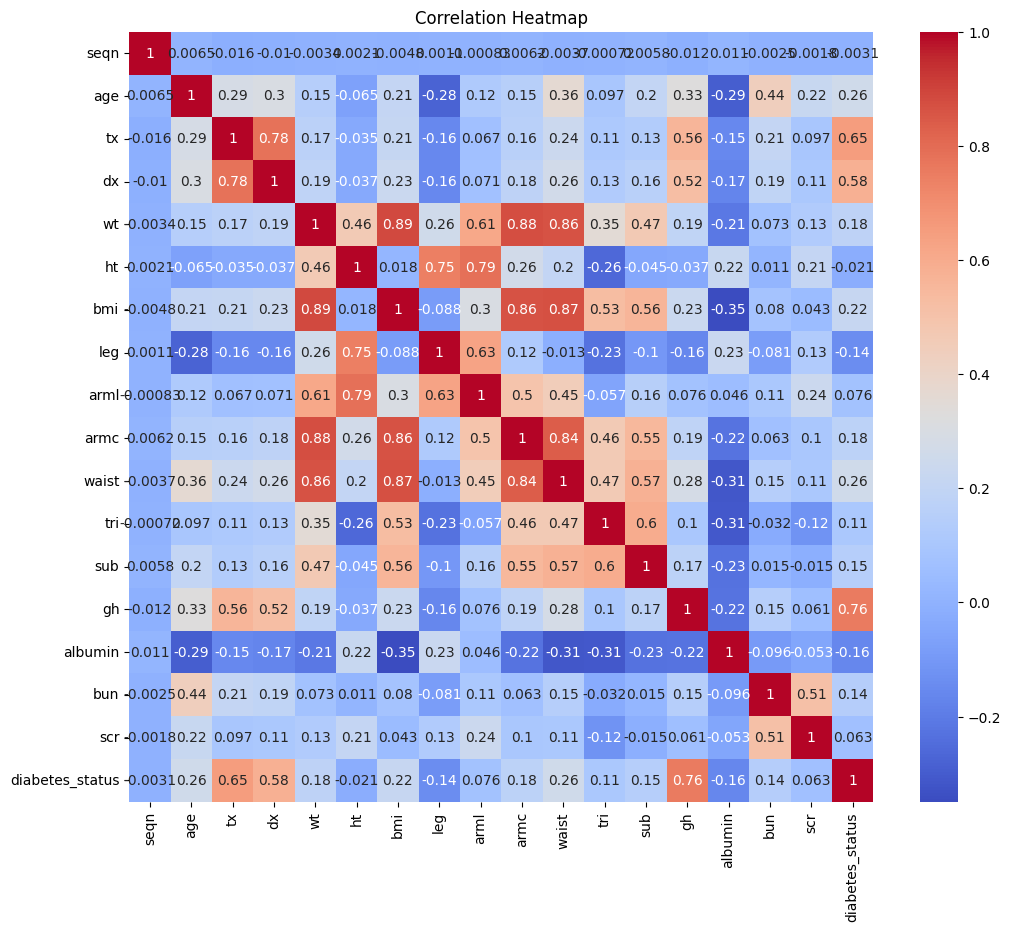

In [273]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

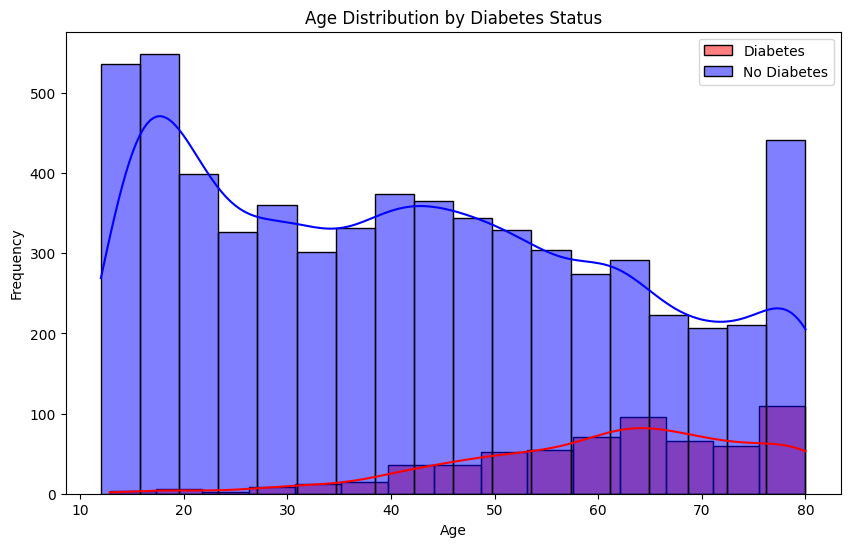

In [274]:
# Age Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.histplot(data[data['gh'] >= 6.5]['age'], color='red', label='Diabetes', kde=True)
sns.histplot(data[data['gh'] < 6.5]['age'], color='blue', label='No Diabetes', kde=True)
plt.title('Age Distribution by Diabetes Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Finding: Diabetes patients tend to be older

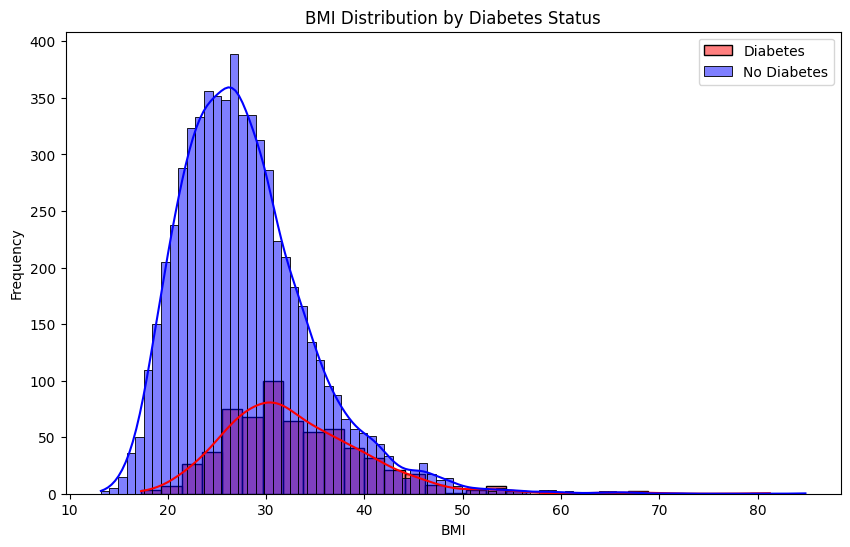

In [275]:
# BMI Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.histplot(data[data['gh'] >= 6.5]['bmi'], color='red', label='Diabetes', kde=True)
sns.histplot(data[data['gh'] < 6.5]['bmi'], color='blue', label='No Diabetes', kde=True)
plt.title('BMI Distribution by Diabetes Status')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Finding: Diabetes patients tend have a higher median BMI

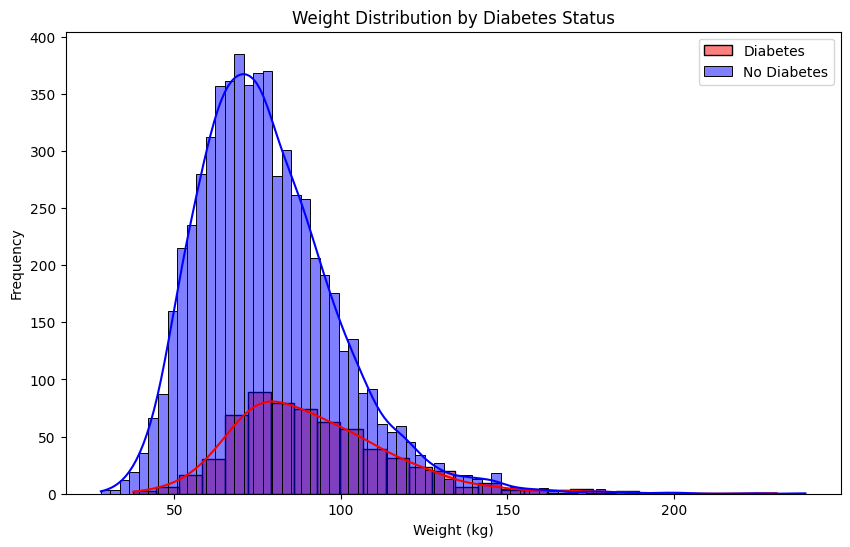

In [276]:
# Weight Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.histplot(data[data['gh'] >= 6.5]['wt'], color='red', label='Diabetes', kde=True)
sns.histplot(data[data['gh'] < 6.5]['wt'], color='blue', label='No Diabetes', kde=True)
plt.title('Weight Distribution by Diabetes Status')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Finding: 
# Weight, which is closely linked to BMI. 
# Also has a slightly higher median weight for diabetes

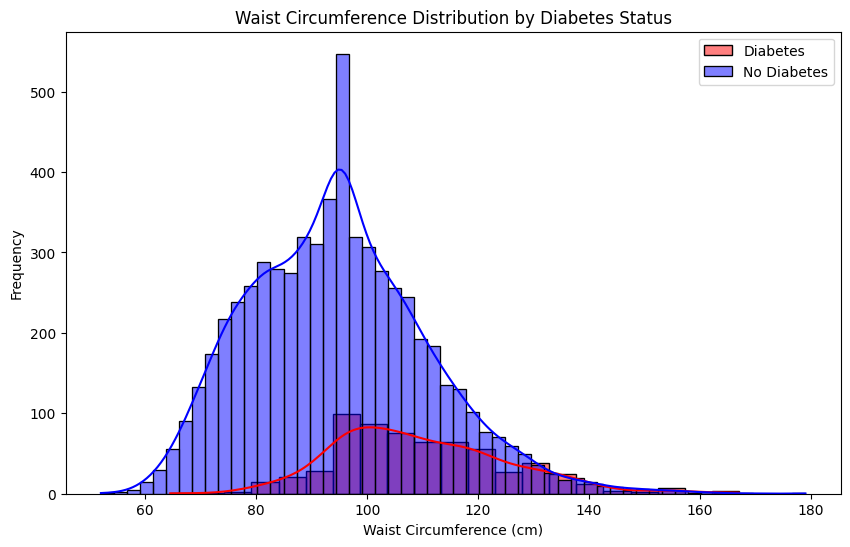

In [277]:
# Waist Circumference Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.histplot(data[data['gh'] >= 6.5]['waist'], color='red', label='Diabetes', kde=True)
sns.histplot(data[data['gh'] < 6.5]['waist'], color='blue', label='No Diabetes', kde=True)
plt.title('Waist Circumference Distribution by Diabetes Status')
plt.xlabel('Waist Circumference (cm)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Finding: 
# Waist size, which is closely linked to BMI. 
# Also has a slightly higher median weight for diabetes

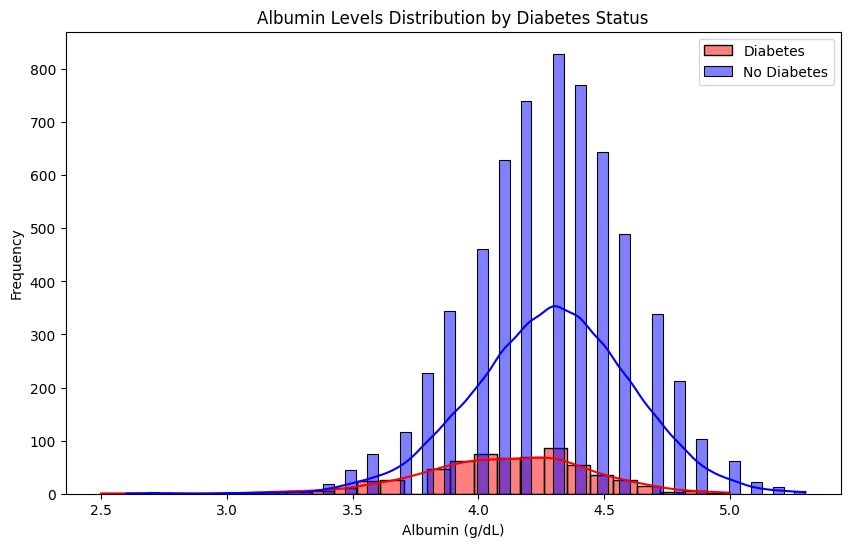

In [278]:
# Albumin Levels Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.histplot(data[data['gh'] >= 6.5]['albumin'], color='red', label='Diabetes', kde=True)
sns.histplot(data[data['gh'] < 6.5]['albumin'], color='blue', label='No Diabetes', kde=True)
plt.title('Albumin Levels Distribution by Diabetes Status')
plt.xlabel('Albumin (g/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Finding: 
# Albumin in diabetes patients are very slightly lower on average than a normal person.

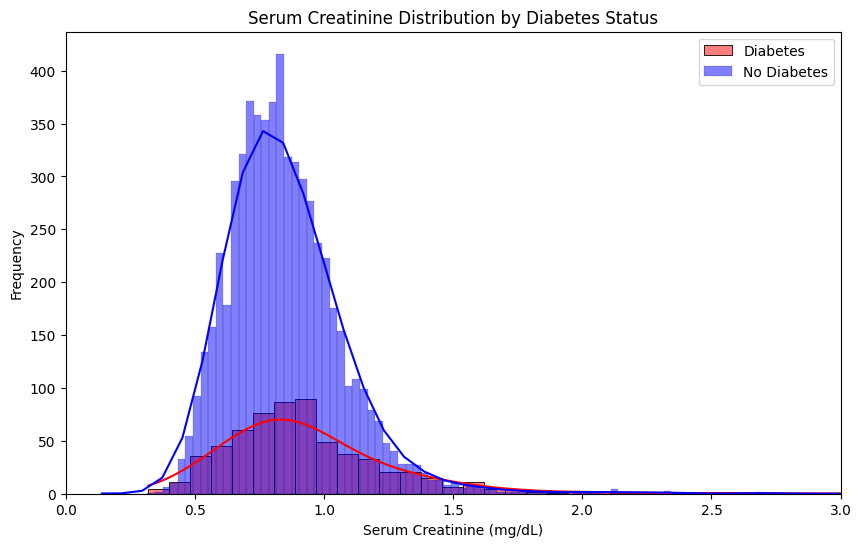

In [279]:
# SCr Distribution by Diabetes Status
plt.figure(figsize=(10, 6))
sns.histplot(data[data['gh'] >= 6.5]['scr'], color='red', label='Diabetes', kde=True)
sns.histplot(data[data['gh'] < 6.5]['scr'], color='blue', label='No Diabetes', kde=True)
plt.title('Serum Creatinine Distribution by Diabetes Status')
plt.xlabel('Serum Creatinine (mg/dL)')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(0, 3)
plt.show()

# Finding: 
# Serum Creatinine doesn't seem to have an effect on diabetes patients

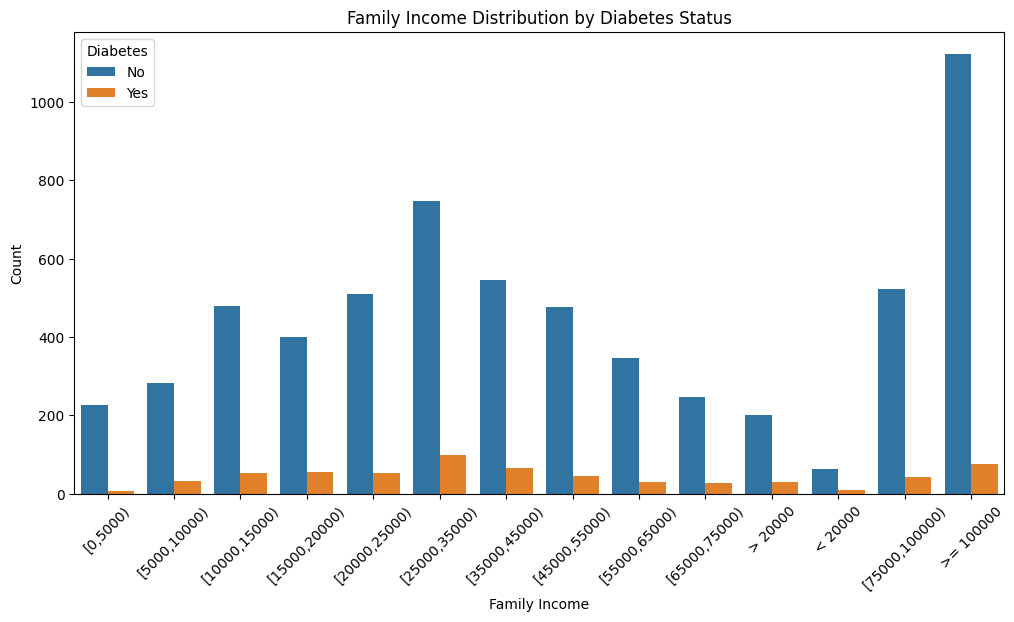

In [280]:
# Family Income Distribution by Diabetes Status
plt.figure(figsize=(12, 6))
sns.countplot(x='income', hue=(data['gh'] >= 6.5), data=data, order=income_types)
plt.title('Family Income Distribution by Diabetes Status')
plt.xlabel('Family Income')
plt.ylabel('Count')
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()



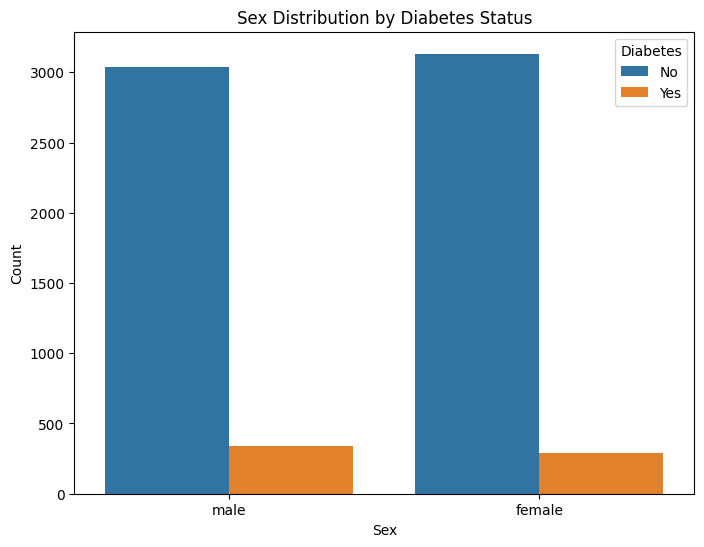

In [281]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sex', hue=(data['gh'] >= 6.5), data=data, order=sex_types)
plt.title('Sex Distribution by Diabetes Status')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.show()

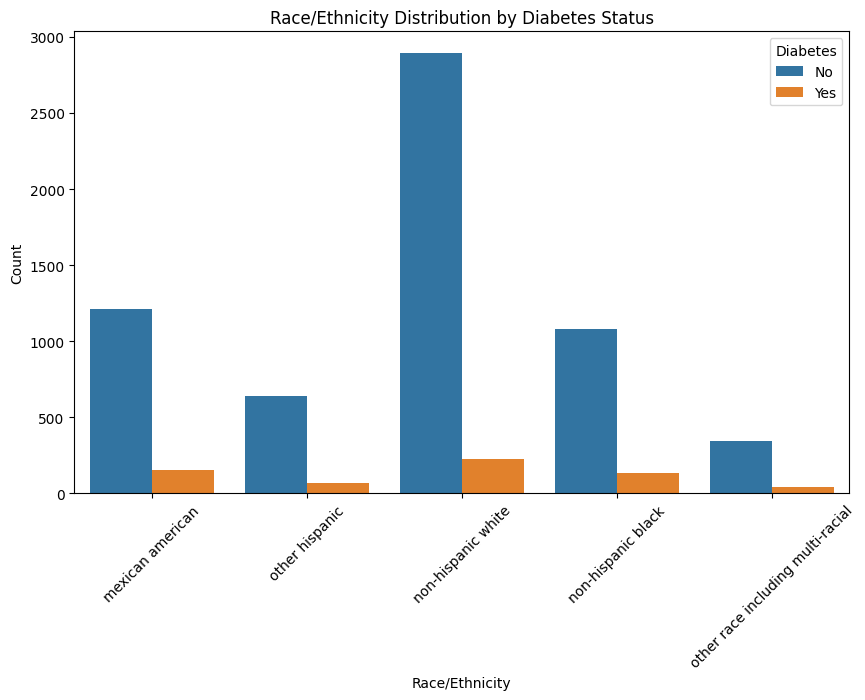

In [282]:
plt.figure(figsize=(10, 6))
sns.countplot(x='re', hue=(data['gh'] >= 6.5), data=data, order=re_types)
plt.title('Race/Ethnicity Distribution by Diabetes Status')
plt.xlabel('Race/Ethnicity')
plt.ylabel('Count')
plt.legend(title='Diabetes', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.show()

In [283]:
## Feature Engineering for our model

# Categorize age into groups
data['age_group'] = pd.cut(data['age'], bins=[0, 18, 35, 50, 65, float('inf')],
                           labels=['<18', '18-35', '36-50', '51-65', '>65'])

# Categorize BMI into groups
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, float('inf')],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Calculate Waist-to-Height Ratio
data['whtr'] = data['waist'] / data['ht']

# Create interaction terms
data['age_bmi_interaction'] = data['age'] * data['bmi']
data['age_whtr_interaction'] = data['age'] * data['whtr']


In [284]:
# Original features
original_features = ['age', 'bmi', 'waist', 'bun', 'scr', 'albumin', 'wt', 'ht']  
# tx and dx is somewhat directly associated with predicting diabetes_status,
# let's not use this in this case

# Engineered features
engineered_features = ['age_bmi_interaction', 'whtr', 'age_whtr_interaction']

# Categorical features that need to be converted to dummy variables
categorical_features = ['sex', 're', 'income', 'bmi_category', 'age_group']

# Combine all features
feature_columns = original_features + engineered_features

In [285]:
data.columns

Index(['seqn', 'sex', 'age', 're', 'income', 'tx', 'dx', 'wt', 'ht', 'bmi',
       'leg', 'arml', 'armc', 'waist', 'tri', 'sub', 'gh', 'albumin', 'bun',
       'scr', 'diabetes_status', 'age_group', 'bmi_category', 'whtr',
       'age_bmi_interaction', 'age_whtr_interaction'],
      dtype='object')

In [286]:
# Convert categorical variables to dummy/indicator variables
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Now, update feature_columns to include the dummy variables
# Exclude the original categorical columns as they are now represented by the dummy variables
excluded_features = ['seqn', 'gh', 'diabetes_status', 'tx', 'dx']
feature_columns = [col for col in data.columns if col not in categorical_features and col not in excluded_features]



In [287]:
print(f"feature columns: {feature_columns}\n---\ndata.columns: {data.columns}") 

feature columns: ['age', 'wt', 'ht', 'bmi', 'leg', 'arml', 'armc', 'waist', 'tri', 'sub', 'albumin', 'bun', 'scr', 'whtr', 'age_bmi_interaction', 'age_whtr_interaction', 'sex_male', 're_non-hispanic black', 're_non-hispanic white', 're_other hispanic', 're_other race including multi-racial', 'income_> 20000', 'income_>= 100000', 'income_[0,5000)', 'income_[10000,15000)', 'income_[15000,20000)', 'income_[20000,25000)', 'income_[25000,35000)', 'income_[35000,45000)', 'income_[45000,55000)', 'income_[5000,10000)', 'income_[55000,65000)', 'income_[65000,75000)', 'income_[75000,100000)', 'bmi_category_Normal', 'bmi_category_Overweight', 'bmi_category_Obese', 'age_group_18-35', 'age_group_36-50', 'age_group_51-65', 'age_group_>65']
---
data.columns: Index(['seqn', 'age', 'tx', 'dx', 'wt', 'ht', 'bmi', 'leg', 'arml', 'armc',
       'waist', 'tri', 'sub', 'gh', 'albumin', 'bun', 'scr', 'diabetes_status',
       'whtr', 'age_bmi_interaction', 'age_whtr_interaction', 'sex_male',
       're_non-h

In [288]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = data[feature_columns]
y = data['diabetes_status']

# Split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the shapes of the resulting sets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (5436, 41)
Testing set shape: (1359, 41)


In [289]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [290]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"ROC-AUC: {roc_auc:.2f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [294]:
# Logistic Regression 
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Evaluate Logistic Regression 
print("\nLogistic Regression Performance:")
evaluate_model(logreg_model, X_test, y_test)

# Precision and recall are pretty low. Lets do some feature selection


Logistic Regression Performance:
Accuracy: 0.90
Precision: 0.43
Recall: 0.07
ROC-AUC: 0.53
              precision    recall  f1-score   support

       False       0.91      0.99      0.95      1224
        True       0.43      0.07      0.13       135

    accuracy                           0.90      1359
   macro avg       0.67      0.53      0.54      1359
weighted avg       0.86      0.90      0.86      1359

[[1211   13]
 [ 125   10]]


C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [291]:
## Feature selection using RFECV

from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Initialize Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Create RFECV (Recursive Feature Elimination with Cross-Validation) object
rfecv = RFECV(estimator=logreg_model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

# Fit RFECV
rfecv.fit(X, y)

# Print the optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

Optimal number of features : 2


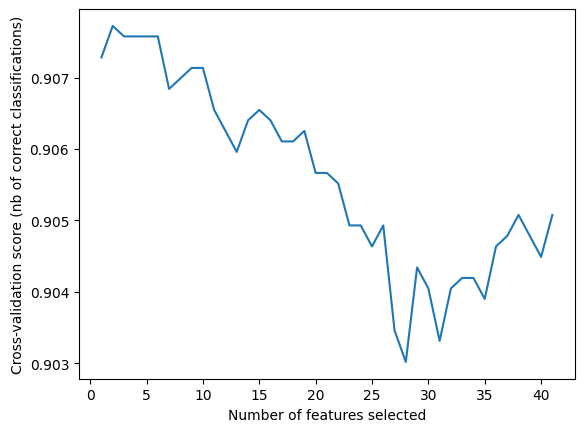

In [292]:
grid_scores = rfecv.cv_results_['mean_test_score']

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(grid_scores) + 1), grid_scores)
plt.show()

In [295]:
### LogReg with RFE feature selection
# Identify which features were selected by RFECV
selected_features = [f for f, s in zip(feature_columns, rfecv.support_) if s]

# Print selected features
print("Selected Features:\n", selected_features)

# Rebuild the model using only selected features
X_selected = X[selected_features]

# Split the dataset into a training set and a testing set
X_train_sel, X_test_sel, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Fit the model
logreg_model.fit(X_train_sel, y_train)

# Evaluate the model
print("Model Performance with Selected Features:")
evaluate_model(logreg_model, X_test_sel, y_test)

# Precision and Recall are now 0. RFE is probably only predicting the majority class (non diabetes)
# This is especially since my dataset is unbalanced. (Num Diabetes << Num Non Diabetes by about 10x)

Selected Features:
 ['age_group_51-65', 'age_group_>65']
Model Performance with Selected Features:
Accuracy: 0.90
Precision: 0.00
Recall: 0.00
ROC-AUC: 0.50
              precision    recall  f1-score   support

       False       0.90      1.00      0.95      1224
        True       0.00      0.00      0.00       135

    accuracy                           0.90      1359
   macro avg       0.45      0.50      0.47      1359
weighted avg       0.81      0.90      0.85      1359

[[1224    0]
 [ 135    0]]


C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarn

In [ ]:
# Log reg with Over-sampling using SMOTE (Synthetic Minority Over-sampling Technique)
# This helps to handle imbalanced datasets

from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [298]:
# Fit the model on resampled data
logreg_model.fit(X_train_res, y_train_res)

# Evaluate the model
print("Logistic Model Performance with Resampled Data:")
evaluate_model(logreg_model, X_test_res, y_test_res)

# We observe that the precision and accuracy significantly improves

Model Performance with Resampled Data:
Accuracy: 0.91
Precision: 0.91
Recall: 0.90
ROC-AUC: 0.91
              precision    recall  f1-score   support

       False       0.91      0.91      0.91      1275
        True       0.91      0.90      0.90      1192

    accuracy                           0.91      2467
   macro avg       0.91      0.91      0.91      2467
weighted avg       0.91      0.91      0.91      2467

[[1165  110]
 [ 118 1074]]


C:\Users\lzyda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [305]:
# Decision Tree Model
dtree_model = DecisionTreeClassifier()

# Fit the model on resampled data
dtree_model.fit(X_train_res, y_train_res)

# Evaluate the model
print("Decision Tree Performance with Resampled Data:")
evaluate_model(dtree_model, X_test_res, y_test_res)

Decision Tree Performance with Resampled Data:
Accuracy: 0.90
Precision: 0.87
Recall: 0.92
ROC-AUC: 0.90
              precision    recall  f1-score   support

       False       0.92      0.87      0.90      1275
        True       0.87      0.92      0.89      1192

    accuracy                           0.90      2467
   macro avg       0.90      0.90      0.90      2467
weighted avg       0.90      0.90      0.90      2467

[[1115  160]
 [  98 1094]]


In [303]:
# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV

# Set the parameters for grid search
param_grid = {
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), 
                           param_grid=param_grid, 
                           cv=5,  # Number of folds
                           n_jobs=-1,  # Use all available cores
                           scoring='accuracy')  # Can use other metrics like 'roc_auc'
grid_search.fit(X_train_res, y_train_res)

# Best parameter set
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2}


In [306]:
# Evaluate the best model found by GridSearchCV
best_dtree_model = grid_search.best_estimator_
print("\nDecision Tree Performance with Best Parameters:")
evaluate_model(best_dtree_model, X_test_res, y_test_res)


Decision Tree Performance with Best Parameters:
Accuracy: 0.90
Precision: 0.90
Recall: 0.90
ROC-AUC: 0.90
              precision    recall  f1-score   support

       False       0.91      0.90      0.91      1275
        True       0.90      0.90      0.90      1192

    accuracy                           0.90      2467
   macro avg       0.90      0.90      0.90      2467
weighted avg       0.90      0.90      0.90      2467

[[1152  123]
 [ 117 1075]]


In [309]:
# Random Forest Model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_res, y_train_res)

# Evaluate Random Forest
print("\nRandom Forest Performance:")
evaluate_model(rf_model, X_test_res, y_test_res)

## Random Forest seems to perform the best. Let's ultimately use and interpret this model


Random Forest Performance:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
ROC-AUC: 0.94
              precision    recall  f1-score   support

       False       0.94      0.95      0.94      1275
        True       0.94      0.94      0.94      1192

    accuracy                           0.94      2467
   macro avg       0.94      0.94      0.94      2467
weighted avg       0.94      0.94      0.94      2467

[[1206   69]
 [  75 1117]]


In [311]:
## Hyperparameter tuning to finetune RF model
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(), 
                           param_grid=param_grid, 
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available cores
                           verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_res, y_train_res)

# Best hyperparameters
print("Best hyperparameters:\n", grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best hyperparameters:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [312]:
# Best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
print("\nRandom Forest Performance with Best Hyperparameters:")
evaluate_model(best_rf_model, X_test_res, y_test_res)


Random Forest Performance with Best Hyperparameters:
Accuracy: 0.95
Precision: 0.95
Recall: 0.94
ROC-AUC: 0.95
              precision    recall  f1-score   support

       False       0.94      0.95      0.95      1275
        True       0.95      0.94      0.94      1192

    accuracy                           0.95      2467
   macro avg       0.95      0.95      0.95      2467
weighted avg       0.95      0.95      0.95      2467

[[1213   62]
 [  71 1121]]


In [313]:
## Lets use RF Model as our main model. 
## Performing CV to validate stability of performance

from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_resampled, y_resampled, cv=5)
print("Cross-validation scores:", cv_scores)

Cross-validation scores: [0.81678152 0.96595055 0.96149169 0.95865424 0.96553122]


In [315]:
## The first fold is quite low, so lets investigate further.
## This could hint that the model may be sensitive to the data input.

# Custom k-fold so we can narrow down any specific folds

from sklearn.model_selection import KFold
import numpy as np

# Number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store the scores and fold data
fold_scores = []
fold_data = []

for train_index, test_index in kf.split(X_resampled):
    X_train_fold, X_test_fold = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train_fold, y_test_fold = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    # Fit the model on this fold
    rf_model.fit(X_train_fold, y_train_fold)
    
    # Evaluate the model
    score = rf_model.score(X_test_fold, y_test_fold)
    fold_scores.append(score)
    
    # Store test data of this fold
    fold_data.append((X_test_fold, y_test_fold, score))

# Print scores for each fold
print("Fold scores:", fold_scores)

## Outlier fold doesn't appear anymore. It may have been just an unlucky streak for the CV

Fold scores: [0.9448723145520875, 0.9387920551276855, 0.9448723145520875, 0.945277665180381, 0.9456609894566099]


In [316]:
## Further outlier fold analysis (not used)

# # Identify the outlier fold
# outlier_fold_index = np.argmin(fold_scores)
# outlier_data = fold_data[outlier_fold_index]

# # Outlier fold's test data
# X_test_outlier, y_test_outlier, outlier_score = outlier_data

# # Analyze the outlier data
# # You can look at distributions of features, class proportions, etc.
# print("Outlier Fold Score:", outlier_score)
# print("Class Distribution in Outlier Fold:", y_test_outlier.value_counts())


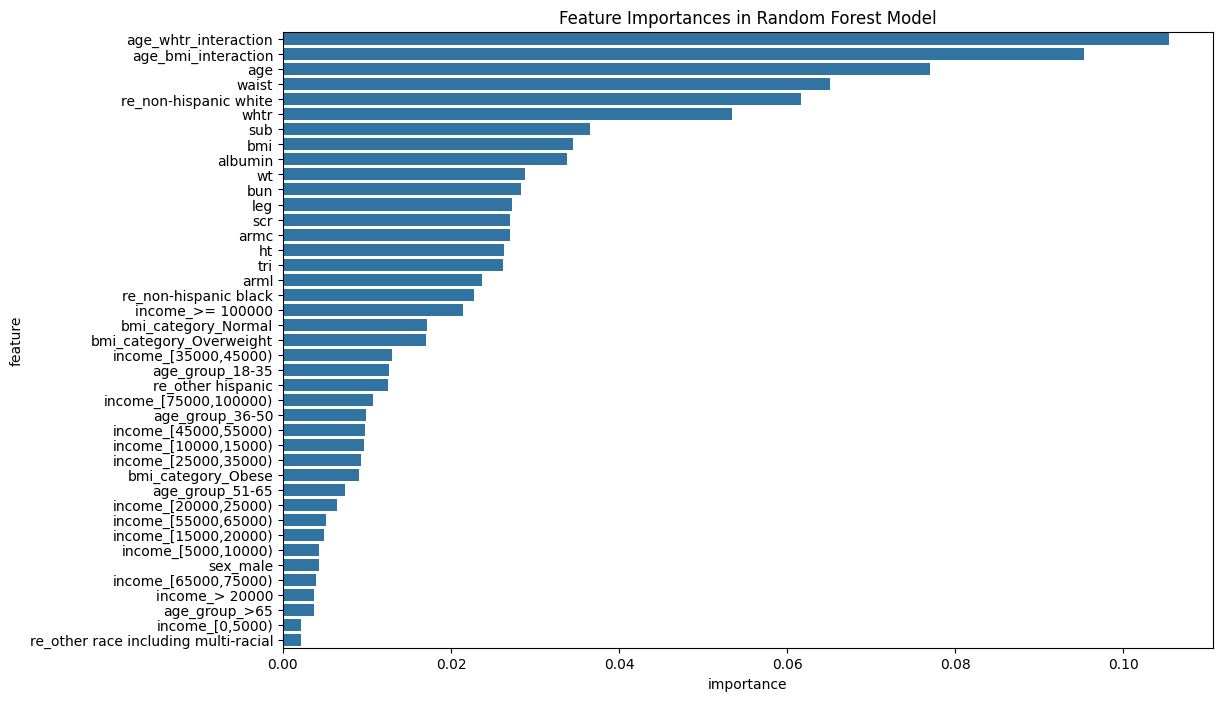

In [318]:
import matplotlib.pyplot as plt

# Get feature importances of finetuned model
importances = best_rf_model.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train_res.columns, 'importance': importances})

# Sort the DataFrame by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plotting
plt.figure(figsize=(12,8))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances in Random Forest Model')
plt.show()

## The graph hints at which features contribute the most to diabetes prediction:
# Top 3: Age & Waist Height ratio interaction, Age & BMI Interaction, Age

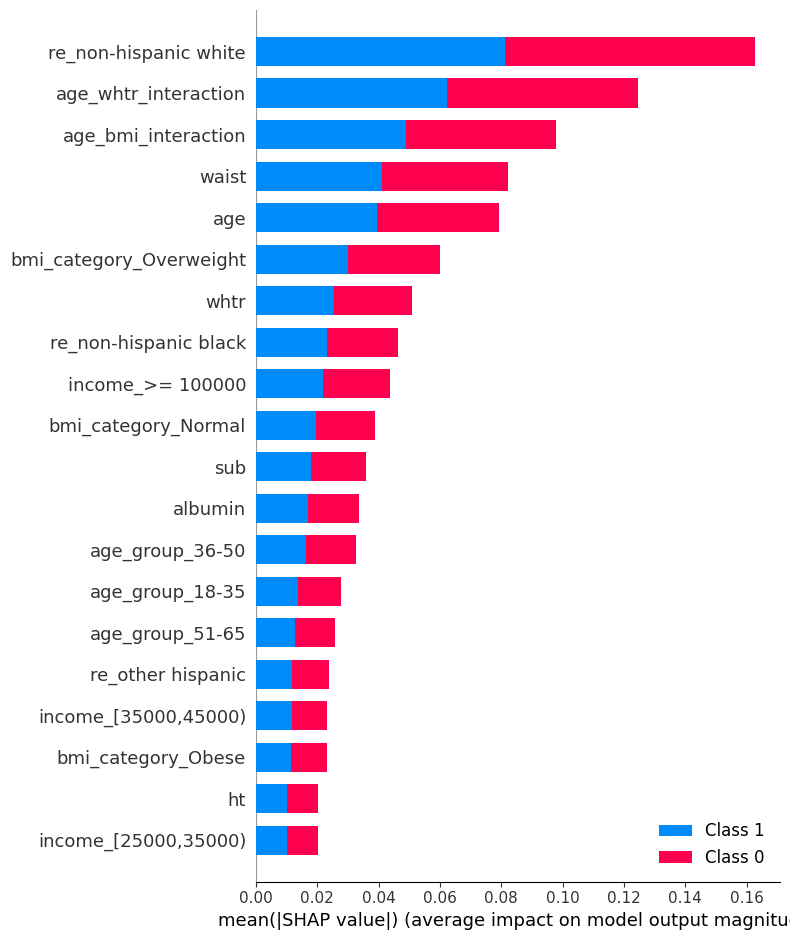

In [322]:
## SHAP (SHapley Additive exPlanations) to interpret model
import shap

# Create the SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_res)

# Plot summary plot
shap.summary_plot(shap_values, X_test_res, plot_type="bar")

In [ ]:
# Using both importance graphs, we can deduce the following important features:

# Importance of Age and one's "body weight"
# - Age & Waist Height ratio interaction, 
# - Age & BMI Interaction, 
# - Age

# Strong correlation to RE
# - H